In [17]:
import cv2
import numpy as np
import os


In [18]:
# Get the training classes names and store them in a list
#Here we use folder names for class names

#train_path = 'dataset/train'  # Names are Aeroplane, Bicycle, Car
train_path = r'C:\My Fieles\Sem1 2020-2021\Machine Vision\Assignment\3\Dataset\training'  # Folder Names are Parasitized and Uninfected
training_names = os.listdir(train_path)

# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
#
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number
#
    
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

# Create feature extraction and keypoint detector objects
    #SIFT is not available anymore in openCV    
# Create List where all the descriptors will be stored
des_list = []

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example
brisk = cv2.BRISK_create(30)

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = brisk.detectAndCompute(im, None)
    des_list.append((image_path, des))   
    
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))  

#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)  

# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 300  #k means with 100 clusters gives lower accuracy for the aeroplane example
voc, variance = kmeans(descriptors_float, k, 1) 


In [19]:
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1


In [20]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

# Scaling the words
#Standardize features by removing the mean and scaling to unit variance
#In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [21]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the KNN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)  #Default of 100 is not converging
clf.fit(im_features, np.array(image_classes))

#Train Random forest to compare how it does against SVM
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(n_estimators = 100, random_state=30)
#clf.fit(im_features, np.array(image_classes))

# Save the SVM
#Joblib dumps Python object into one file
import joblib
joblib.dump((clf, training_names, stdSlr, k, voc), "bovw.pkl", compress=3)    


['bovw.pkl']

In [22]:
import cv2
import numpy as np
import os
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score #sreeni
import joblib

In [23]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
#from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = joblib.load("bovw.pkl")

In [24]:
# Get the path of the testing image(s) and store them in a list
#test_path = 'dataset/test' # Names are Aeroplane, Bicycle, Car
test_path = r'C:\My Fieles\Sem1 2020-2021\Machine Vision\Assignment\3\Dataset\testing'  # Folder Names are Parasitized and Uninfected
#instead of test if you use train then we get great accuracy

testing_names = os.listdir(test_path)

# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
#
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [25]:
# Create feature extraction and keypoint detector objects
    #SIFT is not available anymore in openCV    
# Create List where all the descriptors will be stored
des_list = []

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example
brisk = cv2.BRISK_create(30)

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = brisk.detectAndCompute(im, None)
    des_list.append((image_path, des))   
    
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

In [26]:
# Calculate the histogram of features
#vq Assigns codes from a code book to observations.
from scipy.cluster.vq import vq    
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [27]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

# Scale the features
#Standardize features by removing the mean and scaling to unit variance
#Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

In [28]:
#######Until here most of the above code is similar to Train except for kmeans clustering####

#Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]


#Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))

true_class =['bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'bracelet', 'br

In [29]:
###############################################
#To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()



accuracy =  0.3237037037037037
[[ 86  36  77  41  30]
 [ 39  46  67  79  39]
 [ 75  22 123  24  26]
 [ 60  29  77  93  11]
 [ 56  23  40  62  89]]


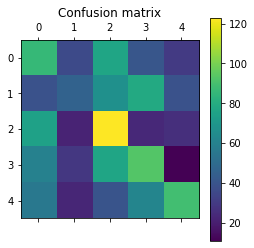

In [30]:
accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions)
print (cm)

showconfusionmatrix(cm)